In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfinv  # use scipy for erfinv

In [5]:
# -----------------------------
# Helper: simple discrete Gaussian sampler
# -----------------------------
def discrete_gaussian_sample(u_bits, sigma=1.0):
    """
    u_bits: uniform random numbers in [0,1)
    sigma: standard deviation
    Returns integer samples ~ N(0, sigma^2)
    """
    # Inversion method for simplicity
    # Map uniform [0,1) to Gaussian via quantiles
    return np.round(sigma * np.sqrt(2) * erfinv(2*u_bits - 1)).astype(int)


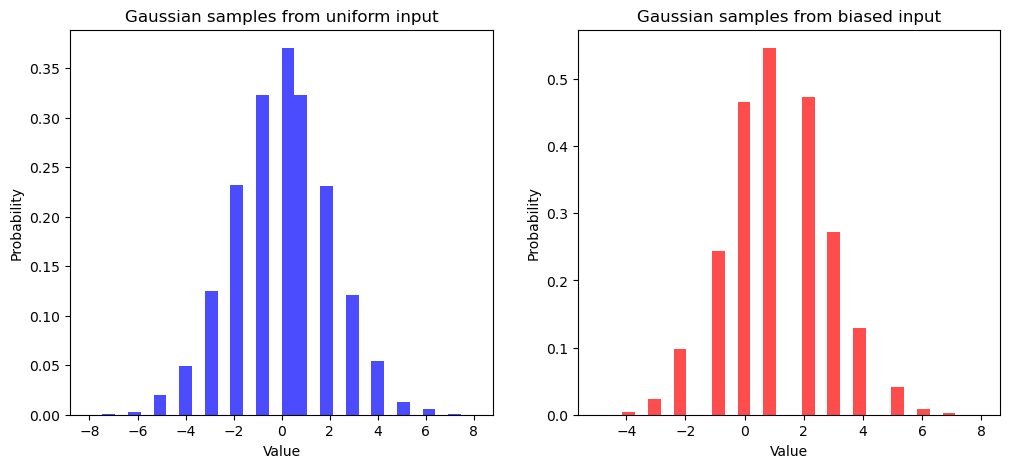

In [6]:
# -----------------------------
# 1. Generate "perfect uniform" input
# -----------------------------
n_samples = 10000
uniform_bits = np.random.rand(n_samples)  # ideal uniform [0,1)
gaussian_uniform = discrete_gaussian_sample(uniform_bits, sigma=2)

# -----------------------------
# 2. Generate "biased" input
# -----------------------------
# Simulate TRNG bias: values skewed towards 1
biased_bits = np.clip(np.random.beta(a=2, b=1, size=n_samples), 0, 1)  # more high values
gaussian_biased = discrete_gaussian_sample(biased_bits, sigma=2)

# -----------------------------
# 3. Plot histograms
# -----------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(gaussian_uniform, bins=30, density=True, color='blue', alpha=0.7)
plt.title("Gaussian samples from uniform input")
plt.xlabel("Value"); plt.ylabel("Probability")

plt.subplot(1,2,2)
plt.hist(gaussian_biased, bins=30, density=True, color='red', alpha=0.7)
plt.title("Gaussian samples from biased input")
plt.xlabel("Value"); plt.ylabel("Probability")

plt.show()

Notes:

- For uniform/ternary we use Chi-square (categorical). For Gaussian, K-S vs. N(0,σ²) is more appropriate than Chi-square on bins.
- Entropy: for discrete laws use Shannon entropy; for (approx) continuous Gaussian the theoretical differential entropy is 0.5*log2(2πeσ²); we report that and a plug-in estimate using the sample variance.

In [7]:
import math, random
from collections import Counter

try:
    import numpy as np
    from scipy import stats
except Exception:
    np = None
    stats = None

# ---------- Utilities ----------
def chi_square_gof(samples, support, expected_probs):
    # samples: list of ints in "support"
    # expected_probs: list same length as support, sum to 1
    n = len(samples)
    counts = Counter(samples)
    chi2 = 0.0
    for x, p in zip(support, expected_probs):
        o = counts.get(x, 0)
        e = n * p
        if e > 0:
            chi2 += (o - e) ** 2 / e
    dof = len(support) - 1
    # p-value via scipy if available; else rough survival using incomplete gamma if numpy present
    if stats:
        pval = 1 - stats.chi2.cdf(chi2, dof)
    else:
        # simple (rough) upper tail using regularized gamma via series (good enough for quick check)
        # For robustness, just return None if no scipy.
        pval = None
    return chi2, dof, pval

def shannon_entropy_discrete(samples, support=None, base=2):
    counts = Counter(samples)
    n = len(samples)
    H = 0.0
    for c in counts.values():
        p = c / n
        H -= p * math.log(p, base)
    return H

def ks_test_gaussian(samples, mu=0.0, sigma=1.0):
    # Two-sided K-S vs. N(mu, sigma^2)
    if stats and np is not None:
        s = np.asarray(samples, dtype=float)
        # create CDF under hypothesized normal
        cdf = lambda x: stats.norm.cdf(x, loc=mu, scale=sigma)
        D, pval = stats.kstest(s, cdf)
        return D, pval
    else:
        # Minimal fallback K-S (empirical CDF vs. analytic CDF on sample points)
        import math
        def Phi(z):
            return 0.5 * (1 + math.erf((z - mu) / (sigma * math.sqrt(2))))
        xs = sorted(samples)
        n = len(xs)
        D = 0.0
        for i, x in enumerate(xs, start=1):
            F_emp = i / n
            F = Phi(x)
            D = max(D, abs(F_emp - F), abs((i-1)/n - F))
        return D, None

def diff_entropy_estimate_gaussian(samples, base=2):
    # For a normal, the *theoretical* differential entropy is:
    # h = 0.5 * log(2*pi*e*sigma^2) (in nats). Convert to bits by / ln(2).
    if np is None:
        # estimate variance manually
        n = len(samples)
        m = sum(samples)/n
        var = sum((x-m)**2 for x in samples)/n
    else:
        var = float(np.var(samples))
    h_bits = 0.5 * math.log(2*math.pi*math.e*var, 2)
    return h_bits, var

# ---------- Example: plug in your sampler outputs ----------
if __name__ == "__main__":
    N = 50000

    # --- Uniform mod q ---
    q = 12289
    # fake sampler for demo:
    uniform_samples = [random.randrange(q) for _ in range(N)]
    support_u = list(range(q))
    expected_u = [1/q]*q
    chi2, dof, p = chi_square_gof(uniform_samples, support_u, expected_u)
    H_emp = shannon_entropy_discrete(uniform_samples, base=2)
    H_theory = math.log(q, 2)
    print(f"[Uniform mod q] chi2={chi2:.1f}, dof={dof}, p={p}")
    print(f"[Uniform mod q] H_emp≈{H_emp:.3f} bits  vs  H_theory=log2(q)={H_theory:.3f} bits")

    # --- Ternary {-1,0,1} ---
    # set your expected probabilities here (typical symmetric: p0=0.5, p±1=0.25 each – adjust to your scheme)
    p_neg, p_zero, p_pos = 0.25, 0.5, 0.25
    ternary_samples = [(-1 if random.random() < p_neg else (0 if random.random() < p_zero/(1-p_neg) else 1))
                       for _ in range(N)]
    support_t = [-1,0,1]
    expected_t = [p_neg, p_zero, p_pos]
    chi2, dof, p = chi_square_gof(ternary_samples, support_t, expected_t)
    H_emp = shannon_entropy_discrete(ternary_samples, support_t, base=2)
    H_theory = -(p_neg*math.log(p_neg,2) + p_zero*math.log(p_zero,2) + p_pos*math.log(p_pos,2))
    print(f"[Ternary] chi2={chi2:.2f}, dof={dof}, p={p}")
    print(f"[Ternary] H_emp≈{H_emp:.3f} bits  vs  H_theory≈{H_theory:.3f} bits")

    # --- Discrete Gaussian ~ approx continuous N(0,sigma^2) ---
    sigma = 3.19
    # demo sampler (Box-Muller with rounding)
    import random, math
    gauss = []
    for _ in range(N//2):
        u1, u2 = random.random(), random.random()
        r = math.sqrt(-2.0*math.log(max(u1,1e-300)))
        z0 = r*math.cos(2*math.pi*u2)
        z1 = r*math.sin(2*math.pi*u2)
        gauss.append(round(sigma*z0))
        gauss.append(round(sigma*z1))
    D, pks = ks_test_gaussian(gauss, mu=0.0, sigma=sigma)  # H0: comes from N(0,σ²)
    h_bits, var = diff_entropy_estimate_gaussian(gauss, base=2)
    h_theory_bits = 0.5*math.log(2*math.pi*math.e*(sigma**2),2)
    print(f"[Gaussian] KS D={D:.4f}, p={pks}")
    print(f"[Gaussian] var≈{var:.3f}, h_emp≈{h_bits:.3f} bits  vs  h_theory≈{h_theory_bits:.3f} bits")


[Uniform mod q] chi2=12422.2, dof=12288, p=0.19563057837905995
[Uniform mod q] H_emp≈13.396 bits  vs  H_theory=log2(q)=13.585 bits
[Ternary] chi2=3.66, dof=2, p=0.16020836976316466
[Ternary] H_emp≈1.496 bits  vs  H_theory≈1.500 bits
[Gaussian] KS D=0.0644, p=5.815865446006113e-181
[Gaussian] var≈10.321, h_emp≈3.731 bits  vs  h_theory≈3.721 bits


### Toy demo: biased TRNG → skewed Gaussian output

This code simulates a biased bit-stream (e.g., your TRNG before perfect conditioning), builds a non-uniform U∈(0,1), then passes it through inverse-CDF to make “Gaussian” samples. You’ll see non-zero mean, wrong variance, and non-Gaussian K-S p-values.

In [11]:
import math, statistics, random

try:
    import numpy as np
    from scipy import stats
except:
    np = None
    stats = None

def biased_bit(p1=0.55):
    return 1 if random.random() < p1 else 0

def biased_uniform(num_bits=24, p1=0.55):
    # Interpret biased bits as fixed-point in [0,1). This yields a *biased* “uniform”.
    x = 0
    for i in range(num_bits):
        x = (x << 1) | biased_bit(p1)
    return x / (1 << num_bits)

def inv_norm_cdf(u):
    # inverse CDF via erfinv
    return math.sqrt(2) * erfinv(2*u - 1)

def make_gaussian_from_biased_uniform(N=50000, sigma=1.0, p1=0.55):
    xs = []
    for _ in range(N):
        u = min(max(biased_uniform(24, p1), 1e-12), 1-1e-12)
        z = inv_norm_cdf(u)           # ~N(0,1) if u ~ U(0,1); but here u is biased
        xs.append(sigma * z)
    return xs

if __name__ == "__main__":
    sigma = 1.0
    samples = make_gaussian_from_biased_uniform(N=50000, sigma=sigma, p1=0.55)

    mean = statistics.fmean(samples)
    var  = statistics.pvariance(samples)
    # crude skewness
    m3 = sum((x-mean)**3 for x in samples)/len(samples)
    s  = math.sqrt(var)
    skew = m3 / (s**3 + 1e-30)

    print(f"Biased->Gaussian: mean≈{mean:.3f}, var≈{var:.3f}, skew≈{skew:.3f}")

    if stats and np is not None:
        D, p = stats.kstest(samples, lambda x: stats.norm.cdf(x, loc=0.0, scale=sigma))
        print(f"K-S vs N(0,{sigma**2}): D={D:.4f}, p={p:.3e}  (small p ⇒ visible deviation)")
    else:
        print("Install scipy for a K-S p-value.")


Biased->Gaussian: mean≈0.182, var≈1.023, skew≈0.104
K-S vs N(0,1.0): D=0.0679, p=9.726e-201  (small p ⇒ visible deviation)


In [12]:
# Example usage:
if __name__ == "__main__":
    test_values = [0.001, 0.025, 0.5, 0.975, 0.999]
    for u in test_values:
        print(f"inv_norm_cdf({u}) = {inv_norm_cdf(u)}")

inv_norm_cdf(0.001) = -3.084639705383466
inv_norm_cdf(0.025) = -1.9590489380232072
inv_norm_cdf(0.5) = 0.0
inv_norm_cdf(0.975) = 1.9590489380232072
inv_norm_cdf(0.999) = 3.084639705383466


In [10]:
import math

def erfinv(x):
    # Approximation valid for |x| < 1
    a = 0.147  # magic constant
    ln = math.log(1 - x*x)
    term = (2/(math.pi*a) + ln/2)
    inside_sqrt = term**2 - ln/a
    return math.copysign(math.sqrt(math.sqrt(inside_sqrt) - term), x)

def inv_norm_cdf(u):
    return math.sqrt(2) * erfinv(2*u - 1)
# Example usage:
if __name__ == "__main__":
    test_values = [0.001, 0.025, 0.5, 0.975, 0.999]
    for u in test_values:
        print(f"inv_norm_cdf({u}) = {inv_norm_cdf(u)}")

inv_norm_cdf(0.001) = -3.084639705383466
inv_norm_cdf(0.025) = -1.9590489380232072
inv_norm_cdf(0.5) = 0.0
inv_norm_cdf(0.975) = 1.9590489380232072
inv_norm_cdf(0.999) = 3.084639705383466
